#  DISASTER & NON DISASTER TWEET ANALYSIS USING Natural Language Processing                                      -- Sai Krishna Madavarapu

### Downloading dependencies using pip installer

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict, Counter
import re, gensim, string
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
import unicodedata
import contractions
from keras.layers import Embedding, LSTM, SpatialDropout1D, Dense
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords



In [123]:
import nltk
stop_words = stopwords.words('english')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [139]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.7/158.7 KB 1.8 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [140]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
import re,unicodedata
from nltk.corpus import wordnet

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [124]:
import os

In [141]:
os.getcwd()

'/Users/apple/Desktop/ITFINAL'

In [142]:
train = pd.read_csv('/Users/apple/Desktop/ITFINAL/train.csv')
test = pd.read_csv('/Users/apple/Desktop/ITFINAL/test.csv')

In [143]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [144]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [145]:
train.isna().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

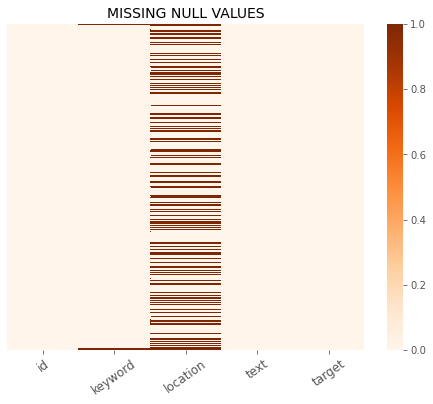

In [146]:
plt.figure(figsize = (8, 6))
sns.heatmap(train.isna(), yticklabels = False, cbar = True, cmap = 'Oranges')
plt.title("MISSING NULL VALUES", fontsize = 14)
plt.xticks(rotation = 35, fontsize = 12)
plt.show()

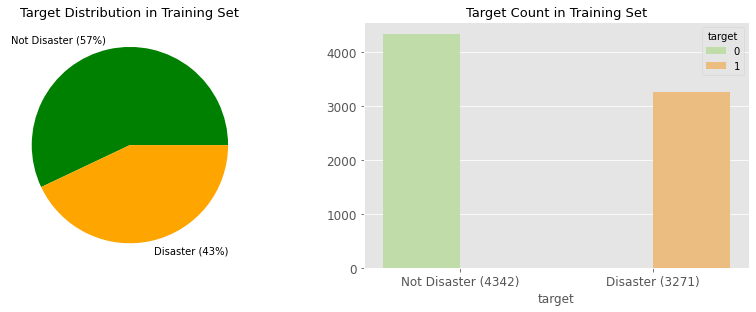

In [164]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'],colors=['green','orange'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1], palette="Spectral_r")


axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()


In [165]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [166]:
def remove_urls(line):
    urlPattern = '\s*https?:\/\/.*[\r\n]*'
    sample =  re.sub(urlPattern,'',line,flags=re.MULTILINE)
    return sample

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_tagged_users(words):    
    pattern = '(@\w+)'
    filtered_users = []
    for word in words:
        sample =  re.sub(pattern,'',word)
        if sample != '':
            filtered_users.append(sample)
    return filtered_users

def filter_stop_words(words,stop_words):
    no_stop_words = []
    full_sentence = ' '.join(words)
    for word in word_tokenize(full_sentence):
        if word not in stop_words:
            no_stop_words.append(word)
    return no_stop_words

def word_contractions(words):
    contractions_words = []
    pattern = '^&\w+\s*;$'
    for word in words:
        sample =  re.sub(pattern,'',word)
        if sample != '':
            contractions_words.append(contractions.fix(sample))
    return contractions_words

def remove_punctuations(words):
    non_punc_words = []
    pattern = '[^a-zA-Z\s]'
    for word in words:
        new_word = re.sub(pattern,'',word)
        if new_word != '':
            non_punc_words.append(new_word)
    return non_punc_words

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 

def lemmatize_word(words):
    lem_words = []
    lem = nltk.stem.WordNetLemmatizer()
    pos_of_words = nltk.pos_tag(words)
    for word,tag in pos_of_words:
        word = word.lower()
        if get_wordnet_pos(tag) != None:
            lem_word = lem.lemmatize(word=word,pos=get_wordnet_pos(tag))
            lem_words.append(lem_word)
        else:
            lem_word = lem.lemmatize(word=word)
            lem_words.append(lem_word)
    return lem_words

def correct_spellings(words):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(words)
    for word in words:
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return corrected_text
        

def clean_tweets(df):
    df = df.copy()
    final_tweet = []
    stop_words = stopwords.words('english')
    for sentence in df['text']:
        ulr_removed_sentence = remove_urls(sentence)
        words = ulr_removed_sentence.split(' ')
        new_words = remove_non_ascii(words)
        non_usr_tagged_words = remove_tagged_users(new_words)
        contraction_words = word_contractions(non_usr_tagged_words)       
        no_stop_words = filter_stop_words(contraction_words,stop_words)
        non_punc_words = remove_punctuations(no_stop_words)
        # spell_check_words = correct_spellings(non_punc_words)
        lem_words = lemmatize_word(non_punc_words)
        pre_clean_sentence = ' '.join(lem_words)
        final_tweet.append(pre_clean_sentence)
    return final_tweet

In [167]:
cleaned_train_tweets = clean_tweets(train)
train['cleaned_tweets'] = cleaned_train_tweets
cleaned_test_tweets = clean_tweets(test)
test['cleaned_tweets'] = cleaned_test_tweets


In [168]:
cleaned_train_tweets

['deed reason hashtag earthquake may allah forgive u',
 'forest fire near la ronge sask canada',
 'resident ask shelter place notify officer evacuation shelter place order expect',
 'number people receive hashtag wildfire evacuation order california',
 'get sent photo ruby hashtag alaska smoke hashtag wildfire pour school',
 'hashtag rockyfire update california hwy number close direction due lake county fire hashtag cafire hashtag wildfire',
 'hashtag flood hashtag disaster heavy rain cause flash flood street manitou colorado spring area',
 'top hill see fire wood',
 'emergency evacuation happen building across street',
 'afraid tornado come area',
 'three people die heat wave far',
 'haha south tampa get flood hah wait second live south tampa go go fvck hashtag flooding',
 'hashtag rain hashtag flood hashtag florida hashtag tampabay hashtag tampa number number day lose count',
 'hashtag flood bago myanmar hashtag arrive bago',
 'damage school bus number multi car crash hashtag breakin

In [169]:
cleaned_test_tweets

['just happen terrible car crash',
 'heard earthquake different city stay safe everyone',
 'forest fire spot pond geese flee across street i save',
 'apocalypse light spokane wildfire',
 'typhoon soudelor kill china taiwan',
 'we shake it earthquake',
 'they would probably still show life arsenal yesterday eh eh',
 'hey how',
 'what nice hat',
 'fuck',
 'no i like cold',
 'nooooooooo do',
 'no tell',
 'what',
 'awesome',
 'birmingham wholesale market ablaze bbc news fire break birmingham s wholesale market',
 'wear short race ablaze',
 'previouslyondoyintv toke makinwauas marriage crisis set nigerian twitter ablaze',
 'check',
 'psa iuam split personality techie follow burner follow',
 'beware world ablaze sierra leone guap',
 'burn man ablaze turban diva',
 'not diss song people take thing run smh eye opener though he set game ablaze',
 'rape victim die set ablaze a yearold girl die burn injury set ablazeu',
 'setting myself ablaze',
 'bin front field house wer set ablaze day flame go

In [182]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(train['cleaned_tweets'])
y_train=train['target']

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

train accuracy: 0.9751740443977407


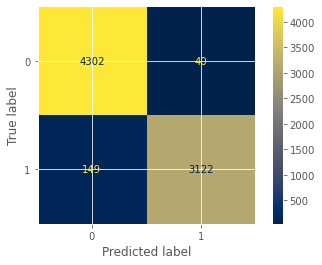

In [215]:
rc =RidgeClassifier()
model0=rc.fit(x_train, y_train)
print("train accuracy:",model0.score(x_train, y_train))

ConfusionMatrixDisplay.from_estimator(rc, x_train, y_train,cmap="cividis")

train accuracy: 0.9431236043609615


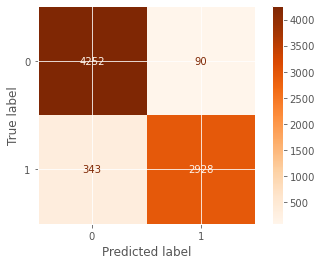

In [200]:
#logistic regression
lr = LogisticRegression(max_iter=2000,penalty='l2')
model1=lr.fit(x_train, y_train)
print("train accuracy:",model1.score(x_train, y_train))
ConfusionMatrixDisplay.from_estimator(lr, x_train, y_train,cmap="Oranges")

train accuracy: 0.9808222776829109


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


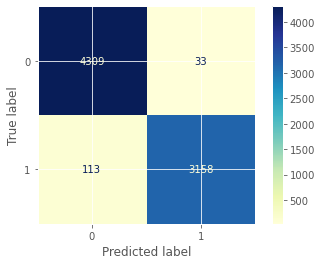

In [217]:
svm =LinearSVC()
model2=svm.fit(x_train, y_train)
print("train accuracy:",model2.score(x_train, y_train))
ConfusionMatrixDisplay.from_estimator(svm, x_train, y_train,cmap="YlGnBu")

train accuracy: 0.9867332194929725


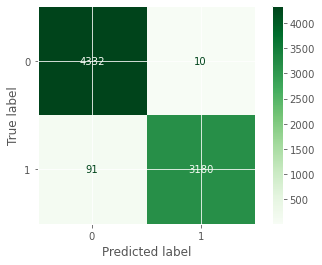

In [208]:
dt=DecisionTreeClassifier()
model3=dt.fit(x_train, y_train)
print("train accuracy:",model3.score(x_train, y_train))
ConfusionMatrixDisplay.from_estimator(dt, x_train, y_train,cmap="Greens")

train accuracy: 0.9866018652305267


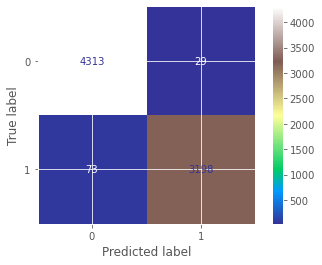

In [225]:
rf=RandomForestClassifier(random_state=120)
model4=rf.fit(x_train, y_train)
print("train accuracy:",model4.score(x_train, y_train))
ConfusionMatrixDisplay.from_estimator(rf, x_train, y_train,cmap="terrain")

train accuracy: 0.7879942204124524


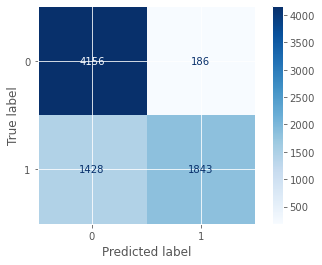

In [204]:
gbm=GradientBoostingClassifier()
model5=gbm.fit(x_train, y_train)
print("train accuracy:",model5.score(x_train, y_train))
ConfusionMatrixDisplay.from_estimator(gbm, x_train, y_train,cmap="Blues")

train accuracy: 0.7609352423486142


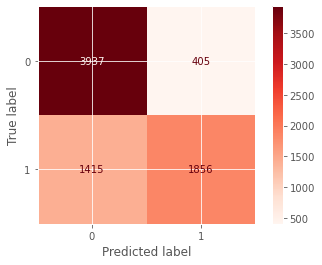

In [212]:
ada=AdaBoostClassifier()
model6=ada.fit(x_train, y_train)
print("train accuracy:",model6.score(x_train, y_train))

ConfusionMatrixDisplay.from_estimator(ada, x_train, y_train,cmap="Reds")

train accuracy: 0.8499934322868777


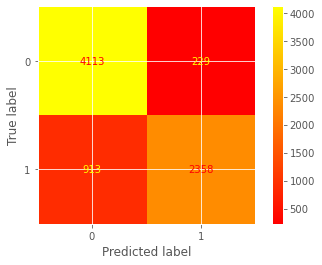

In [227]:
xgb = XGBClassifier(random_state=1234)
model7=xgb.fit(x_train, y_train)
print("train accuracy:",model7.score(x_train, y_train))

ConfusionMatrixDisplay.from_estimator(xgb, x_train, y_train,cmap="autumn")